## Solving Odyssey TSP with Simulated Annealing and Genetic Algorithms

The objective of the problem is to find a shortest route which traverses each city exactly once, before returning to the starting city.

In [43]:
# Import nessecary libraries
import numpy as np
import pandas as pd
import math
import random
import networkx as nx
import matplotlib.pyplot as plt

We have each city marked in a CSV as a pair of (x, y) coordinates. Use pandas to read the CSV into a dataframe. 

In [44]:
df = pd.read_csv("ulysis22TSP.csv", index_col=0)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
Index,,,,,,,,,,,,,,,,,,,,,
X,38.24,39.57,40.56,36.26,33.48,37.56,38.42,37.52,41.23,41.17,...,38.15,37.51,35.49,39.36,38.09,36.09,40.44,40.33,40.37,37.57
Y,20.42,26.15,25.32,23.12,10.54,12.19,13.11,20.44,9.10,13.05,...,15.35,15.17,14.32,19.56,24.36,23.00,13.57,14.15,14.23,22.56


Plot the cities to better visualise the problem.

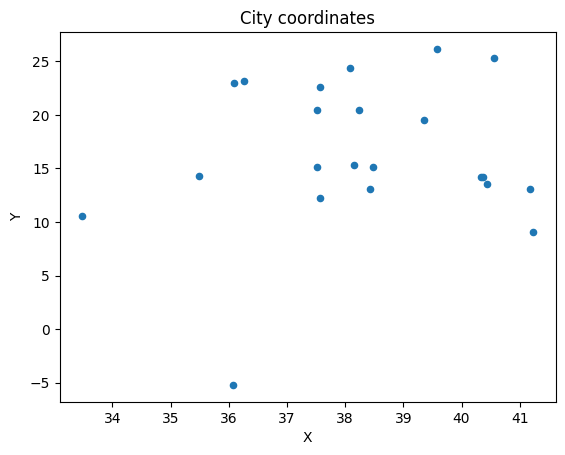

In [45]:
df.T.plot(kind = 'scatter', x='X', y='Y')
plt.title('City coordinates')
plt.show()

### Simulated Annealing

Here I have written a class which contains the nessecary functions to perform Simulated Annealing, inspired by the process of annealing in metallurgy in which metal is heated to a high temperature and then gradually cooled. We define functions which calculate the distance between two given cities as the euclidean norm, and another to calculate the total distance of the current route. We also define a temperature function which defines the annealing schedule, how the temperature is reduced throughout cycle, and a fucntion which generates 'neighbouring' candidate routes using the 2-opt algorithm. 
The temperature function is defined by the user. In this case, we use the following update rule:
$$T_{n+1} = T_{n}\cdot(1-\frac{10}{N})$$
Where N is the user defined maximum number of iterations. As the temperature tends to zero, the algorithm converges to hill descent.

In [46]:
class Simulated_Annealing:
    
    def __init__(self, cities, max_iter, init_temp, alpha):
        self.cities = cities
        self.max_iter = max_iter
        self.init_temp = init_temp
        self.alpha = alpha
        self.progress = []
        self.temp_history = [init_temp]
    
    # Returns euclidean distance between a pair of cities' coordinates
    def distance_between_cities(self, c1, c2):
        return math.dist(c1,c2)

    # Returns the total traversed distance of a candidate route
    def total_distance(self, route):
        distance = 0
        for i in range(len(route)-1):
            distance += self.distance_between_cities(route[i], route[i+1])
        distance += self.distance_between_cities(route[-1], route[0])
        return distance
    
    # Returns updated temperature according to defined annealing schedule.
    def temp_fn(self, temp, iter):
        return temp*(1-10/self.max_iter)

    # Returns a new candidate route using 2-opt
    def get_neighbour(self, route):
        i = random.randint(0, len(route) - 1)
        j = random.randint(i + 1, len(route))
        new_route = np.concatenate((route[:i], route[i:j+1][::-1], route[j+1:])) # Generate two cities and reverse traversal order between them
        return new_route

    # Performs simulated annealing
    def simulated_annealing(self):
        route = self.cities
        best_route = route
        current_distance = self.total_distance(best_route)
        best_distance = [current_distance]
        self.progress.append(current_distance)
        temp = self.init_temp
        iter = 0
        while iter < self.max_iter: # Continue until desired number of iterations is reached
            new_route = self.get_neighbour(route) # Get new candidate
            new_distance = self.total_distance(new_route)
            delta = new_distance - current_distance
            if delta < 0 or np.random.random() < np.exp(-delta/temp): # If candiate is better, accept it. If not better, sometimes accept anyway
                route = new_route                                                 
                current_distance = new_distance
                self.progress.append(current_distance)
            if current_distance < best_distance[-1]: # Check if this is the best so far
                best_route = route
                best_distance.append(current_distance)
            temp = self.temp_fn(temp, iter) # Update temperature
            self.temp_history.append(temp)
            iter += 1
        return best_distance, best_route

In [47]:
cities = df.T.to_numpy()
odyssey = Simulated_Annealing(cities, 10000, 100, 0.5)
best_distance, best_route = odyssey.simulated_annealing()
temps = odyssey.temp_history

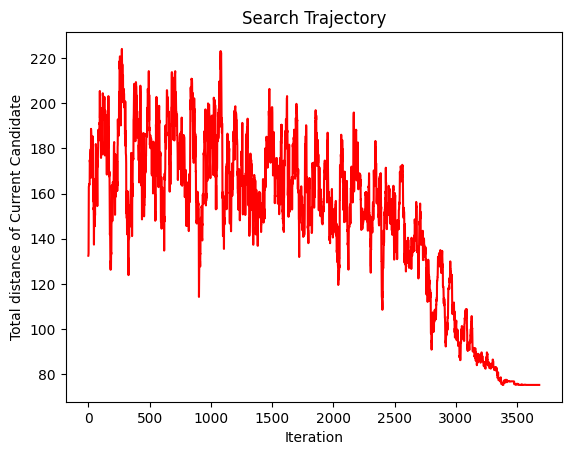

In [48]:
progress = odyssey.progress
plt.title("Search Trajectory")
plt.xlabel("Iteration")
plt.ylabel("Total distance of Current Candidate")
plt.plot(progress, color ="red")
plt.show()

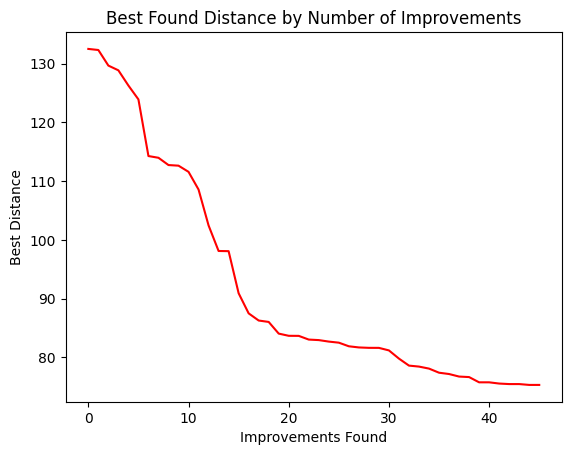

In [49]:
plt.title("Best Found Distance by Number of Improvements")
plt.xlabel("Improvements Found")
plt.ylabel("Best Distance")
plt.plot(best_distance, color ="red")
plt.show()

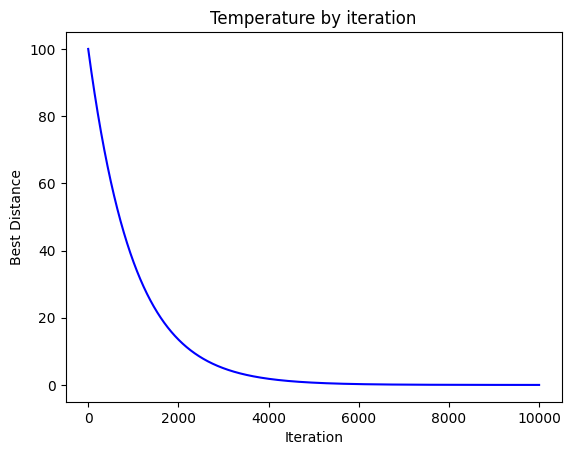

In [50]:
plt.title("Temperature by iteration")
plt.xlabel("Iteration")
plt.ylabel("Best Distance")
plt.plot(temps, color ="blue")
plt.show()

In [51]:
print(best_distance[-1])

75.30970120611254


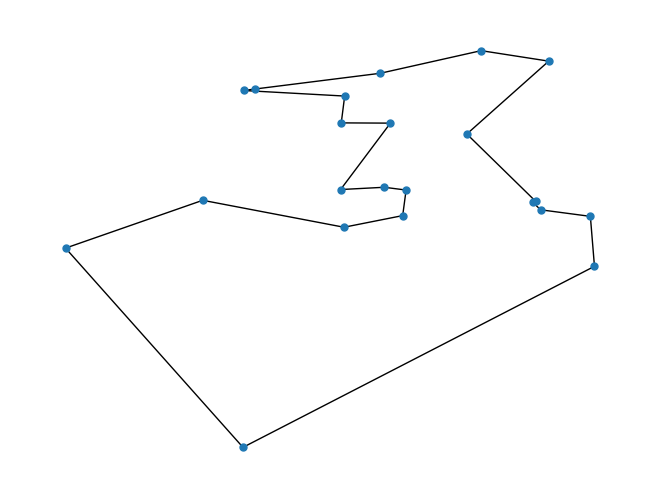

In [52]:
G = nx.Graph()

# Add nodes to graph
for i, coord in enumerate(best_route):
    G.add_node(i, pos=coord)

# Add edges to form a cycle
for i in range(len(best_route)):
    G.add_edge(i, (i+1) % len(best_route))

# Get node positions
pos = nx.get_node_attributes(G, 'pos')

# Plot graph
nx.draw(G, pos, with_labels=False, node_size=25)
plt.show()

In [53]:

distances = []
for i in range(30):
    odyssey = Simulated_Annealing(cities, 1000000, 100, 0.5)
    best_distance, best_route = odyssey.simulated_annealing()
    distances.append(best_distance[-1])


In [54]:
distances = np.array(distances)
mean_simulated_annealing = np.mean(distances)
std_simulated_annealing = np.std(distances)
print(mean_simulated_annealing, std_simulated_annealing)

75.30970120611254 2.5945352296482633e-15


### Genetic Algorithm